In [1]:
import platform, socket
if 'mac' in platform.platform():
    BASE_DIR = "/Users/marco/phd/vr_to_pc/"
    DATA_DIR = "/Users/marco/phd/data/vr_to_pc"
elif 'calcolatore' in socket.gethostname():
    BASE_DIR = "/home/marco/phd/vr_to_pc/"
    DATA_DIR = "/home/marco/phd/data/vr_to_pc"
else:
    BASE_DIR = "/home/marco/vr_to_pc/"
    DATA_DIR = "/media/data/marco/vr_to_pc"

import sys
sys.path.append(BASE_DIR)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task-statistics" data-toc-modified-id="Task-statistics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task statistics</a></span></li><li><span><a href="#Train-model" data-toc-modified-id="Train-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train model</a></span><ul class="toc-item"><li><span><a href="#Evaluate-performance" data-toc-modified-id="Evaluate-performance-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Evaluate performance</a></span></li></ul></li><li><span><a href="#Ratemaps" data-toc-modified-id="Ratemaps-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ratemaps</a></span><ul class="toc-item"><li><span><a href="#Grid-scores" data-toc-modified-id="Grid-scores-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Grid scores</a></span></li></ul></li><li><span><a href="#Manifold-distance" data-toc-modified-id="Manifold-distance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Manifold distance</a></span></li><li><span><a href="#Neural-sheet" data-toc-modified-id="Neural-sheet-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Neural sheet</a></span></li><li><span><a href="#Connectivity" data-toc-modified-id="Connectivity-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Connectivity</a></span><ul class="toc-item"><li><span><a href="#Sort-weights" data-toc-modified-id="Sort-weights-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Sort weights</a></span></li></ul></li><li><span><a href="#Path-integration" data-toc-modified-id="Path-integration-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Path integration</a></span></li><li><span><a href="#SVD" data-toc-modified-id="SVD-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>SVD</a></span></li><li><span><a href="#Null-model-(low-pass-filtered-noise)" data-toc-modified-id="Null-model-(low-pass-filtered-noise)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Null model (low-pass filtered noise)</a></span></li><li><span><a href="#Boundary-extension" data-toc-modified-id="Boundary-extension-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Boundary extension</a></span></li><li><span><a href="#Head-direction-and-speed-tuning" data-toc-modified-id="Head-direction-and-speed-tuning-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Head direction and speed tuning</a></span></li><li><span><a href="#Border-score" data-toc-modified-id="Border-score-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Border score</a></span></li></ul></div>

In [2]:
import numpy as np
import torch

from tqdm import tqdm
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
# If GPUs available, select which to train on
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
from utils import generate_run_ID, load_trained_weights
from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN
from trainer import Trainer

In [5]:
# Training options and hyperparameters
class Options:
    pass
options = Options()

options.save_dir = 'experiments'
options.n_steps = 100 # 100_000     # number of training steps
options.batch_size = 5_000 # 200     # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096             # number of grid cells
options.place_cell_rf = np.round(0.17*(0.635/2.2), 5) # 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'RNN'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 0.635 # 2.2       # width of training environment
options.box_height = 0.635 # 2.2      # height of training environment

# additional options which were not given, but necessary
options.device = 'cuda' if torch.cuda.is_available() else 'cpu'

options.run_ID = generate_run_ID(options)

In [6]:
print("original total number of datapoints")
print(f"{100_000 * 200 * options.sequence_length * 1_000:,f}") # where 1_000 is the number of epochs

original total number of datapoints
400,000,000,000.000000


In [7]:
print("current total number of datapoints (w/ similar results)")
print(f"{options.n_steps * options.batch_size * options.sequence_length * 100:,f}") # where 100 is the number of epochs

current total number of datapoints (w/ similar results)
1,000,000,000.000000


In [8]:
# If you've trained with these params before, will restore trained model
place_cells = PlaceCells(options)
model = RNN(options, place_cells).cuda()
trajectory_generator = TrajectoryGenerator(options, place_cells)
trainer = Trainer(options, model, trajectory_generator)

# # Load example weights stored on github
# weight_dir = options.save_dir + '/example_trained_weights.npy'
# load_trained_weights(model, trainer, weight_dir)

Initializing new model from scratch.
Saving to: experiments/steps_20_batch_5000_RNN_4096_relu_rf_004907_DoG_True_periodic_False_lr_00001_weight_decay_00001


# My Data

In [9]:
import os
import numpy as np

load_dirs = [
    os.path.join(
        DATA_DIR, 'box', 'run',
        f"exp_dim0.635_fps50_s3600_seed{s:04d}"
    ) for s in range(1, 1_020+1)
]

thetas, positions, velocities, rot_velocities =\
    [], [], [], []
print("\n[*] Loading simulations from:")
for ld in load_dirs:
    print(ld)
    # load riab data
    thetas.append(np.expand_dims(
        np.load(os.path.join(ld, "riab_simulation/thetas.npy")).astype(np.float32),
        axis=-1
    ))
    positions.append(np.load(os.path.join(ld, "riab_simulation/positions.npy")).astype(np.float32))
    velocities.append(np.load(os.path.join(ld, "riab_simulation/velocities.npy")).astype(np.float32))
    rot_velocities.append(np.expand_dims(
        np.load(os.path.join(ld, "riab_simulation/rot_velocities.npy")).astype(np.float32),
        axis=-1
    ))


[*] Loading simulations from:
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0001
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0002
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0003
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0004
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0005
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0006
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0007
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0008
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0009
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0010
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0011
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0012
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0013
/media/data/marco/vr_to_pc/box/run/exp_dim0.635_fps50_s3600_seed0014
/me

In [10]:
vel = np.stack(velocities, axis=0)
pos = np.stack(positions, axis=0)
hd = np.stack(thetas, axis=0)
rot_vel = np.stack(rot_velocities, axis=0)

print(vel.shape, pos.shape, hd.shape, rot_vel.shape)

(1020, 180000, 2) (1020, 180000, 2) (1020, 180000, 1) (1020, 180000, 1)


In [11]:
positions = []
thetas = []

subsample = 10
for idx in range(subsample):
    positions.append(pos[:, idx::subsample, ...])
    thetas.append(hd[:, idx::subsample, ...])

In [12]:
pos = np.concatenate(positions)
hd = np.concatenate(thetas)

print(pos.shape, hd.shape)

(10200, 18000, 2) (10200, 18000, 1)


In [13]:
from simulation.riab_simulation.utils import calculate_rot_velocity

rot_vel = np.apply_along_axis(
    calculate_rot_velocity,
    axis=1,
    arr=hd
)

vel = np.concatenate([
    np.diff(pos, axis=1),
    np.zeros((pos.shape[0], 1, 2))
], axis=1).astype(np.float32)

In [14]:
dist_riab = np.sqrt(np.sum(np.power(np.diff(pos, axis=1), 2), axis=-1))
print("Distances shape", dist_riab.shape)
print("dt = 0.02 (50 fps)")
print(f"Average distance between consecutive points: {dist_riab.mean():.4f} m")
print(f"Average distance in a window of 3,600 seconds: {dist_riab.sum(axis=-1).mean():.4f} m")

Distances shape (10200, 17999)
dt = 0.02 (50 fps)
Average distance between consecutive points: 0.0181 m
Average distance in a window of 3,600 seconds: 326.4743 m


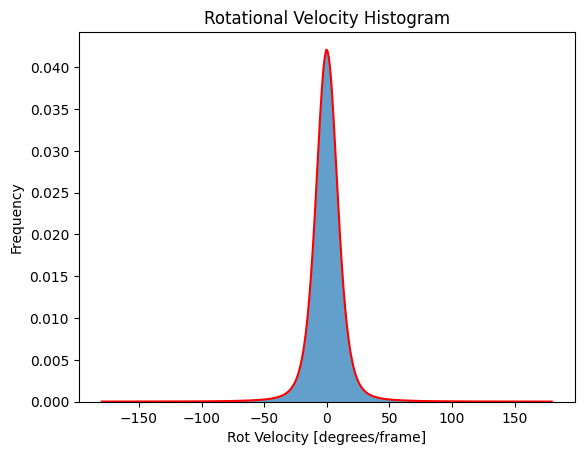

In [15]:
rot_vel_hist = rot_vel.flatten()*180/np.pi # degrees per frame

rv_riab_counts, rv_riab_bin_edges, _ = plt.hist(rot_vel_hist, bins=500, alpha=0.7, density=True)

bin_centers = 0.5 * (rv_riab_bin_edges[1:] + rv_riab_bin_edges[:-1])

plt.plot(bin_centers, rv_riab_counts, '-', color='red', alpha=1)

plt.title('Rotational Velocity Histogram')
plt.xlabel('Rot Velocity [degrees/frame]')
plt.ylabel('Frequency')
plt.show()

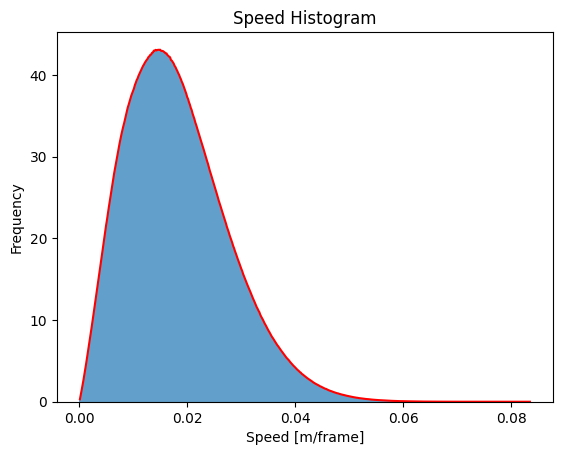

In [16]:
speed_hist = dist_riab.flatten()

s_riab_counts, s_riab_bin_edges, _ = plt.hist(speed_hist, bins=500, alpha=0.7, density=True)

bin_centers = 0.5 * (s_riab_bin_edges[1:] + s_riab_bin_edges[:-1])

plt.plot(bin_centers, s_riab_counts, '-', color='red', alpha=1)

plt.title('Speed Histogram')
plt.xlabel('Speed [m/frame]')
plt.ylabel('Frequency')
plt.show()

In [17]:
import torch

class WindowedPredictionDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        velocity, rot_velocity, positions,
        window_size
    ):
        self.n_exp = len(velocity)
        self.windows_in_exp = velocity.shape[1] - window_size - 1

        self.velocity = torch.from_numpy(velocity)
        # self.rot_velocity = torch.from_numpy(rot_velocity)

        self.positions = torch.from_numpy(positions)
        self.positions -= (options.box_width / 2)

        self.window_size = window_size

    def __getitem__(self, index):
        # Ensure that the index is within the range of the dataset
        if not (0 <= index < len(self)):
            raise ValueError("Index out of range")
        
        exp = index // self.windows_in_exp
        index_in_exp = index % self.windows_in_exp

        vel = self.velocity[exp]
        # rot_vel = self.rot_velocity[exp]
        pos = self.positions[exp]

        window_slice = (index_in_exp, index_in_exp + self.window_size)        
        # v = torch.concatenate(
        #     [vel[window_slice[0]:window_slice[1], ...],
        #     rot_vel[window_slice[0]:window_slice[1], ...]],
        #     axis=-1
        # )
        vel = vel[window_slice[0]:window_slice[1], ...]
        init_pos = pos[window_slice[0], ...][None, ...]
        pos = pos[window_slice[0]+1:window_slice[1]+1, ...]

        return vel, pos, init_pos

    def __len__(self):
        return self.n_exp * self.windows_in_exp


In [18]:
dataloader_train = torch.utils.data.DataLoader(
    WindowedPredictionDataset(
        vel[:-1], rot_vel[:-1], pos[:-1], window_size=options.sequence_length
    ),
    shuffle=True, batch_size=options.batch_size
)

print("\tDataloader length:", len(dataloader_train))
print()
for i, batch in enumerate(dataloader_train):
    if i == 0:
        v, p, ip = batch

        print(f"\tBATCH {i}")
        print('\t', v.shape, v.dtype)
        print('\t', p.shape, p.dtype)
        print('\t', ip.shape, ip.dtype)
        print()

        break
    
print()
print("total number of datapoints (w/ rat in a box)")
print(f"{len(dataloader_train) * options.batch_size * options.sequence_length:,f}")

	Dataloader length: 36674

	BATCH 0
	 torch.Size([5000, 20, 2]) torch.float32
	 torch.Size([5000, 20, 2]) torch.float32
	 torch.Size([5000, 1, 2]) torch.float32


total number of datapoints (w/ rat in a box)
3,667,400,000.000000


In [19]:
dataloader_test = torch.utils.data.DataLoader(
    WindowedPredictionDataset(
        vel[-1:], rot_vel[-1:], pos[-1:], window_size=options.sequence_length
    ),
    shuffle=True, batch_size=options.batch_size
)

# Task statistics

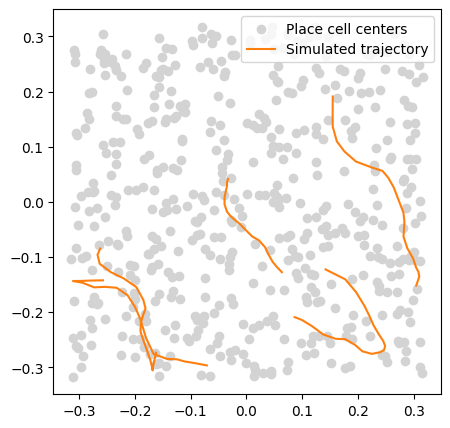

In [20]:
# Plot a few sample trajectories
# inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
inputs, pos, pc_outputs = trajectory_generator.get_test_batch_mine(dataloader_test)
us = place_cells.us.cpu()
pos = pos.cpu()

plt.figure(figsize=(5,5))
plt.scatter(us[:,0], us[:,1], c='lightgrey', label='Place cell centers')
for i in range(5):
    plt.plot(pos[:,i,0],pos[:,i,1], label='Simulated trajectory', c='C1')
    if i==0:
        plt.legend();

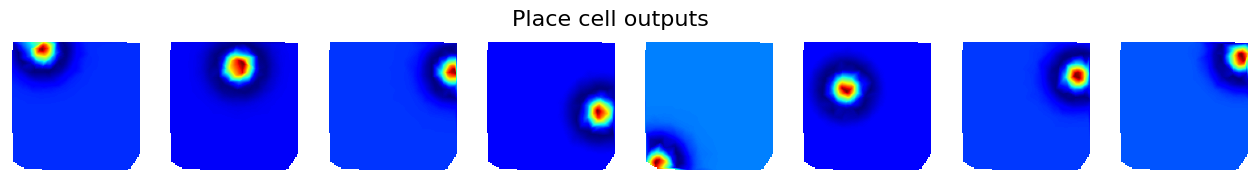

In [21]:
# Plot a few place cell outputs
pc_outputs = pc_outputs.reshape(-1, options.Np).detach().cpu()
pc = place_cells.grid_pc(pc_outputs[::100], res=100)

plt.figure(figsize=(16,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(pc[i], cmap='jet')
    plt.axis('off')
        
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

# plt.tight_layout()

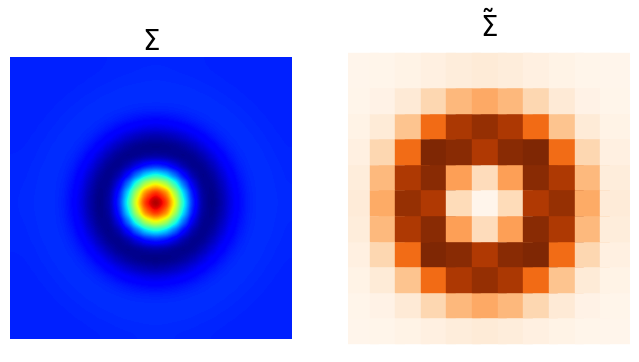

In [22]:
# Visualize place cell covariance matrix
Cmean = place_cells.compute_covariance(res=30)

# Fourier transform
Ctilde = np.fft.fft2(Cmean)
Ctilde[0,0] = 0

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(Cmean, cmap='jet', interpolation='gaussian')
plt.axis('off')
plt.title(r'$\Sigma$', fontsize=20)

plt.subplot(122)
width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
plt.scatter(x2,y2,c=np.abs(Ctilde)[idxs][:,idxs],
            s=600, cmap='Oranges', marker='s')

plt.axis('equal')
plt.axis('off')
plt.title(r'$\tilde \Sigma$', fontsize=20)
plt.axis('off');

In [23]:
traj = trajectory_generator.generate_trajectory(
    box_width=options.box_width,
    box_height=options.box_height,
    batch_size=1_000_000
)
speed = traj['ego_v']
vel = np.stack([
    traj['ego_v'] * np.cos(traj['target_hd']),
    traj['ego_v'] * np.sin(traj['target_hd'])
], axis=-1)
pos = np.stack([traj['target_x'], traj['target_y']], axis=-1)
hd = traj['target_hd']
init_pos = np.stack([traj['init_x'], traj['init_y']], axis=-1)

print(vel.shape, pos.shape, init_pos.shape)

(1000000, 20, 2) (1000000, 20, 2) (1000000, 1, 2)


In [24]:
dist = np.sqrt(np.sum(np.power(np.diff(pos, axis=1), 2), axis=-1))
print("Distances shape", dist.shape)
print("dt = 0.02 (50 fps)")
print(f"Average distance between consecutive points: {dist.mean():.4f} m")
print(f"Average distance in a window of {options.sequence_length} steps: {dist.sum(axis=-1).mean():.4f} m")

Distances shape (1000000, 19)
dt = 0.02 (50 fps)
Average distance between consecutive points: 0.0183 m
Average distance in a window of 20 steps: 0.3483 m


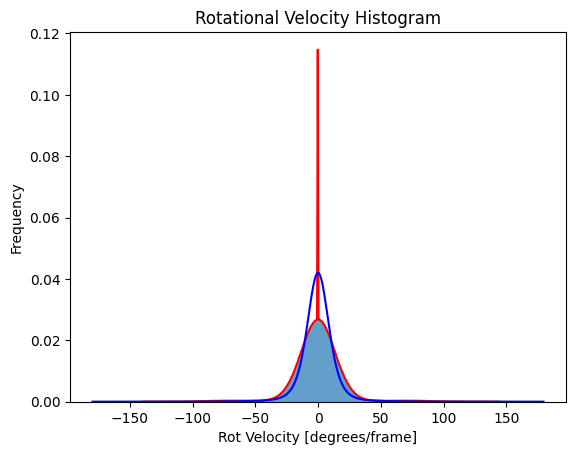

In [25]:
from simulation.riab_simulation.utils import calculate_rot_velocity

rot_vel = np.apply_along_axis(
    calculate_rot_velocity,
    axis=1,
    arr=hd
)

rot_vel_hist = rot_vel.flatten()*180/np.pi # degrees per second

counts, bin_edges, _ = plt.hist(rot_vel_hist, bins=500, alpha=0.7, density=True)

bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

plt.plot(bin_centers, counts, '-', color='red', alpha=1)

# riab
bin_centers = 0.5 * (rv_riab_bin_edges[1:] + rv_riab_bin_edges[:-1])
plt.plot(bin_centers, rv_riab_counts, '-', color='blue', alpha=1)

# plt.xlim([-70, 70])

plt.title('Rotational Velocity Histogram')
plt.xlabel('Rot Velocity [degrees/frame]')
plt.ylabel('Frequency')
plt.show()

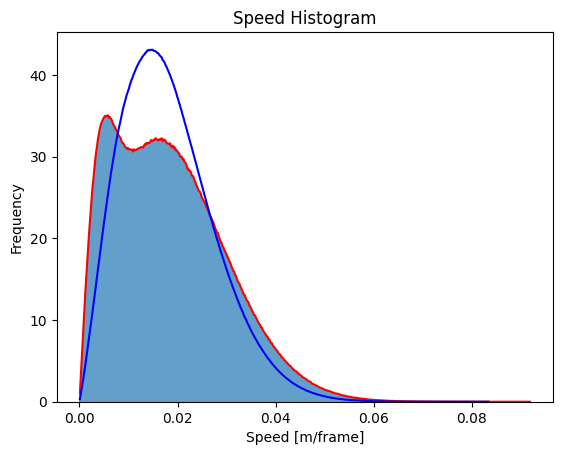

In [26]:
speed_hist = speed.flatten()

counts, bin_edges, _ = plt.hist(speed_hist, bins=500, alpha=0.7, density=True)

bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

plt.plot(bin_centers, counts, '-', color='red', alpha=1)

# riab
bin_centers = 0.5 * (s_riab_bin_edges[1:] + s_riab_bin_edges[:-1])
plt.plot(bin_centers, s_riab_counts, '-', color='blue', alpha=1)

plt.title('Speed Histogram')
plt.xlabel('Speed [m/frame]')
plt.ylabel('Frequency')
plt.show()

# Train model

In [27]:
# trainer.train(n_epochs=100, n_steps=options.n_steps, save=True)
trainer.train_mine(n_epochs=100, dl=dataloader_train, save=True)

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(trainer.err, c='black')

plt.title('Decoding error (m)'); plt.xlabel('train step')
plt.subplot(122)
plt.plot(trainer.loss, c='black');
plt.title('Loss'); plt.xlabel('train step');

Epoch: 1/100. Batch 0/36674. Loss: 6.37. Err: 26.32cm
Epoch: 1/100. Batch 1/36674. Loss: 6.37. Err: 26.64cm
Epoch: 1/100. Batch 2/36674. Loss: 6.37. Err: 26.78cm
Epoch: 1/100. Batch 3/36674. Loss: 6.37. Err: 26.52cm
Epoch: 1/100. Batch 4/36674. Loss: 6.36. Err: 26.47cm
Epoch: 1/100. Batch 5/36674. Loss: 6.36. Err: 26.56cm
Epoch: 1/100. Batch 6/36674. Loss: 6.36. Err: 26.18cm
Epoch: 1/100. Batch 7/36674. Loss: 6.36. Err: 26.24cm
Epoch: 1/100. Batch 8/36674. Loss: 6.36. Err: 26.22cm
Epoch: 1/100. Batch 9/36674. Loss: 6.35. Err: 26.03cm
Epoch: 1/100. Batch 10/36674. Loss: 6.35. Err: 26.07cm
Epoch: 1/100. Batch 11/36674. Loss: 6.35. Err: 26.13cm
Epoch: 1/100. Batch 12/36674. Loss: 6.35. Err: 25.81cm
Epoch: 1/100. Batch 13/36674. Loss: 6.34. Err: 26.11cm
Epoch: 1/100. Batch 14/36674. Loss: 6.34. Err: 26.18cm
Epoch: 1/100. Batch 15/36674. Loss: 6.34. Err: 26.24cm
Epoch: 1/100. Batch 16/36674. Loss: 6.34. Err: 26.14cm
Epoch: 1/100. Batch 17/36674. Loss: 6.34. Err: 26.31cm
Epoch: 1/100. Batch 

KeyboardInterrupt: 